# Patches windows and their use in interpolation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pylops

from invwidget import inversion_widget
from scipy.signal import convolve
from scipy.sparse.linalg import LinearOperator as spLinearOperator
from pylops.basicoperators import *
from pylops.utils import dottest
from pylops.optimization.basic import cgls
from pylops.optimization.sparsity import fista
from pylops import LinearOperator, MatrixMult, MemoizeOperator
from pylops.signalprocessing import FFT2D, Sliding1D, Sliding2D, Patch2D, Patch3D
from pylops.signalprocessing.Sliding1D import sliding1d_design
from pylops.signalprocessing.Sliding2D import sliding2d_design
from pylops.signalprocessing.Sliding3D import sliding3d_design
from pylops.signalprocessing.Patch2D import patch2d_design
from pylops.signalprocessing.Patch3D import patch3d_design

from visual import *

## 1d sliding

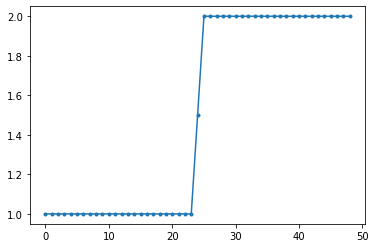

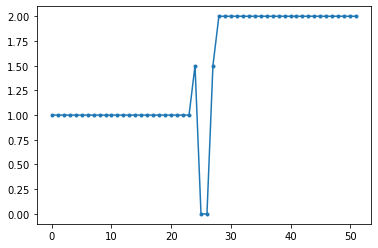

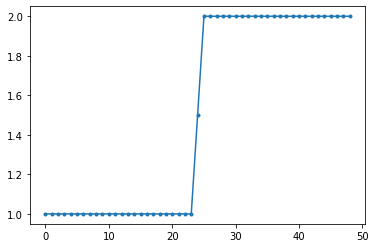

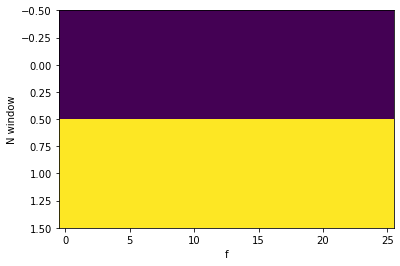

In [2]:
dimd = 49
nwin = 26
nover = 3
nwins, dim, mwin_inends, dwin_inends = sliding1d_design(dimd, nwin, nover, nwin)

Op = Identity(nwin, nwin)
Sop = Sliding1D(Op.H, dim, dimd, nwin, nover, tapertype='cosine')

x = np.ones(dim)
x[dim//2:]=2
y = Sop * x
xinv = Sop.div(y)

yinv = Sop * xinv

plt.figure()
plt.plot(y, '.-')

plt.figure()
plt.plot(xinv, '.-')

plt.figure()
plt.plot(yinv, '.-')

plt.figure()
plt.imshow(np.abs(x.reshape(Sop.dims)))
plt.xlabel('f')
plt.ylabel('N window')
plt.axis('tight');

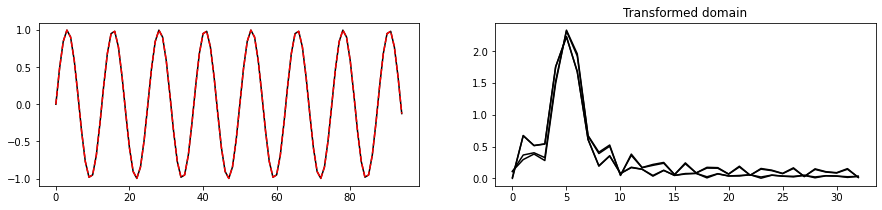

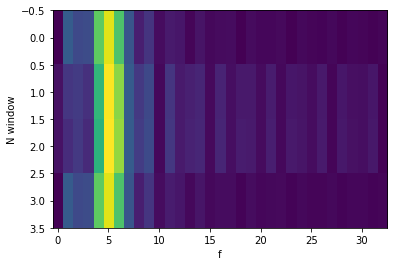

In [3]:
nwins = 4
nwin = 26
nover = 3
nop = 64
dimd = nwin * nwins - 3 * nover

t = np.arange(dimd) * 0.004
data = np.sin(2 * np.pi * 20 * t)

nwins, dim, mwin_inends, dwin_inends = sliding1d_design(dimd, nwin, nover, (nop + 2) // 2)
Op = pylops.signalprocessing.FFT(nwin, nfft=nop, real=True)
Slid = pylops.signalprocessing.Sliding1D(
    Op.H, dim, dimd, nwin, nover, tapertype=None)

x = Slid.H * data.ravel()

Slid = pylops.signalprocessing.Sliding1D(
    Op.H, dim, dimd, nwin, nover, tapertype="cosine"
)

reconstructed_data = Slid * x.ravel()

fig, axs = plt.subplots(1, 2, figsize=(15, 3))
axs[0].plot(data, "k", label="Data")
axs[0].plot(reconstructed_data, "--r", label="Rec Data")
axs[1].set_title("Original domain")
axs[1].plot(np.abs(x).T, "k")
axs[1].set_title("Transformed domain")

plt.figure()
plt.imshow(np.abs(x.reshape(Slid.dims)))
plt.xlabel('f')
plt.ylabel('N window')
plt.axis('tight');

## 2d sliding

In [4]:
par = {'ox':-140, 'dx':2, 'nx':140,
       'ot':0, 'dt':0.004, 'nt':200,
       'f0': 20}

v = 1500
t0 = [0.2, 0.4, 0.5]
px = [0, 0, 0]
pxx = [1e-5, 5e-6, 1e-20]
amp = [1., -2, 0.5]

# Create axis
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)

# Create wavelet
wav = pylops.utils.wavelets.ricker(t[:41], f0=par['f0'])[0]

# Generate model
_, data = pylops.utils.seismicevents.parabolic2d(x, t, t0, px,
                                                 pxx, amp, wav)
data = data[:, 60:]
pad = 12
data = np.pad(data, ((pad, pad), (pad, pad)), mode='edge')

In [5]:
dimsd = data.shape
nwin = 26
nover = 4

Op = FFT2D((nwin, dimsd[1]), nffts=(256, 256))

nwins, dims, mwin_inends, dwin_inends = sliding2d_design(dimsd, nwin, nover, (256, 256))
Sop = Sliding2D(Op.H, dims, dimsd, nwin, nover,
                tapertype=None)
Sop1 = Sliding2D(Op.H, dims, dimsd, nwin, nover,
                 tapertype='cosine')
y = data.copy()
x = Sop.H * y.ravel()
x = x.reshape(dims)
xreshaped = x.reshape(Sop1.dims)
y1 = Sop1 * x.ravel()
y1 = np.real(y1).reshape(dimsd)

xinv = Sop1.div(y.ravel(), 50)

yinv = Sop1 * xinv.ravel()
yinv = np.real(yinv).reshape(dimsd)

dottest(Sop, Sop.shape[0],  Sop.shape[1], complexflag=2, atol=1e-2)

True

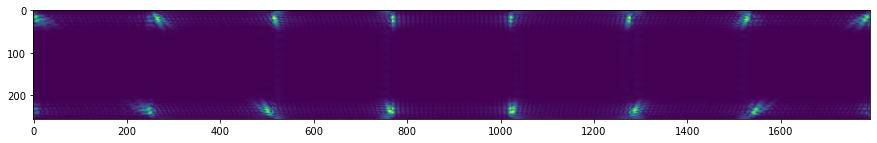

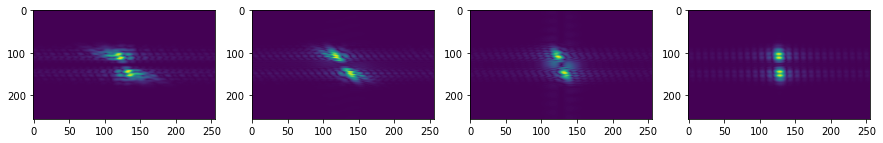

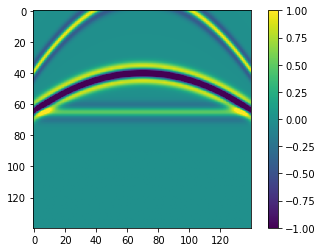

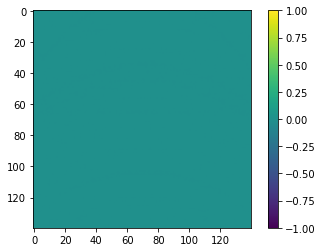

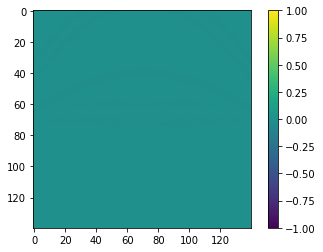

In [6]:
plt.figure(figsize=(15, 2))
plt.imshow(np.abs(x).T)
#plt.colorbar()
plt.axis('tight')

fig, axs = plt.subplots(1, 4, figsize=(15, 2))
for i in range(4):
    axs[i].imshow(np.fft.fftshift(np.abs(xreshaped[i]).T))
    axs[i].axis('tight')
          
plt.figure()
plt.imshow(y[pad:-pad,pad:-pad].T, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.imshow(y[pad:-pad,pad:-pad].T-y1[pad:-pad,pad:-pad].T, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.imshow(y[pad:-pad,pad:-pad].T-yinv[pad:-pad,pad:-pad].T, vmin=-1, vmax=1)
plt.colorbar();

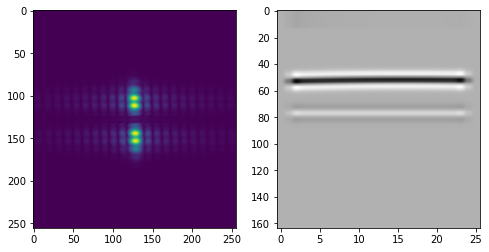

In [7]:
slides_inend = np.arange(0, 7*256*256+1, 256*256)

islide = 3

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(xinv.ravel()[slides_inend[islide]:slides_inend[islide+1]].reshape(256, 256).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Op.H * xinv.ravel()[slides_inend[islide]:slides_inend[islide+1]].T).reshape(nwin, dimsd[1]).T), 
              cmap='gray')
axs[1].axis('tight');

## 3d sliding

In [8]:
par = {
    "oy": -15,
    "dy": 2,
    "ny": 14,
    "ox": -18,
    "dx": 2,
    "nx": 18,
    "ot": 0,
    "dt": 0.004,
    "nt": 50,
    "f0": 30,
}

vrms = [200, 200]
t0 = [0.05, 0.1]
amp = [1.0, -2]

# Create axis
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)

# Create wavelet
wav = pylops.utils.wavelets.ricker(t[:41], f0=par["f0"])[0]

# Generate model
_, data = pylops.utils.seismicevents.hyperbolic3d(x, y, t, t0, vrms, vrms, amp, wav)

# Sliding window plan
winsize = (5, 6)
overlap = (2, 3)
npx = 21
px = np.linspace(-5e-3, 5e-3, npx)
npy = 25
py = np.linspace(-5e-3, 5e-3, npy)
dimsd = data.shape

# Sliding window transform without taper
Op = pylops.signalprocessing.Radon3D(
    t,
    np.linspace(-par["dy"] * winsize[0] // 2, par["dy"] * winsize[0] // 2, winsize[0]),
    np.linspace(-par["dx"] * winsize[1] // 2, par["dx"] * winsize[1] // 2, winsize[1]),
    py,
    px,
    centeredh=True,
    kind="linear",
    engine="numba",
)

nwins, dims, mwin_inends, dwin_inends = sliding3d_design(dimsd, winsize, overlap, (npy, npx, par["nt"]))
Slid = pylops.signalprocessing.Sliding3D(
    Op, dims, dimsd, winsize, overlap, (npy, npx), tapertype=None
)

radon = Slid.H * data.ravel()
radon = radon.reshape(Slid.dims) # nwins[0], nwins[1], npx, npx, par["nt"])

Slid = pylops.signalprocessing.Sliding3D(
    Op, dims, dimsd, winsize, overlap, (npy, npx), tapertype="cosine"
)

reconstructed_data = Slid * radon.ravel()
reconstructed_data = reconstructed_data.reshape(Slid.dimsd)

radoninv = pylops.LinearOperator(Slid, explicit=False).div(data.ravel(), niter=10)
reconstructed_datainv = Slid * radoninv.ravel()

radoninv = radoninv.reshape(nwins[0], nwins[1], npy, npx, par["nt"])
reconstructed_datainv = reconstructed_datainv.reshape(dimsd)

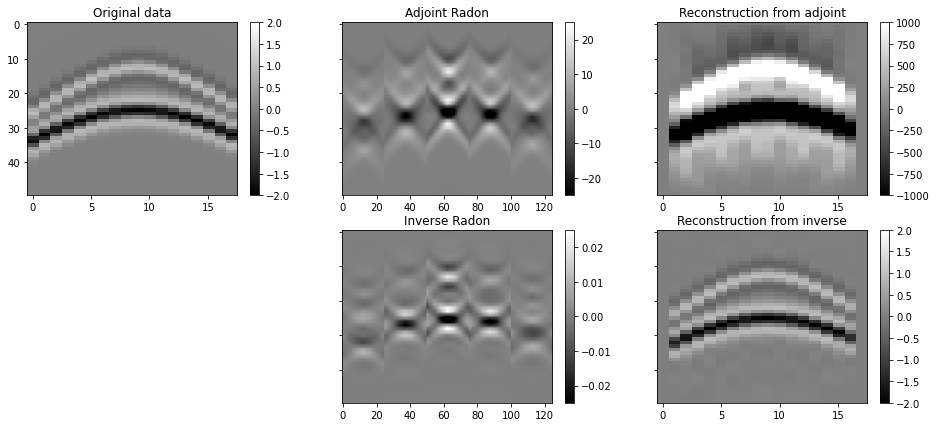

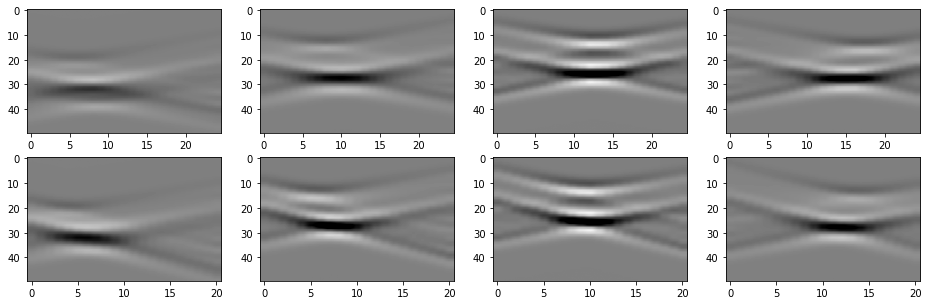

In [9]:
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(16, 7))
im = axs[0][0].imshow(data[par["ny"] // 2].T, cmap="gray", vmin=-2, vmax=2)
axs[0][0].set_title("Original data")
plt.colorbar(im, ax=axs[0][0])
axs[0][0].axis("tight")
im = axs[0][1].imshow(
    radon[nwins[0] // 2, :, :, npx // 2].reshape(nwins[1] * npy, par["nt"]).T,
    cmap="gray",
    vmin=-25,
    vmax=25,
)
axs[0][1].set_title("Adjoint Radon")
plt.colorbar(im, ax=axs[0][1])
axs[0][1].axis("tight")
im = axs[0][2].imshow(
    reconstructed_data[par["ny"] // 2].T, cmap="gray", vmin=-1000, vmax=1000
)
axs[0][2].set_title("Reconstruction from adjoint")
plt.colorbar(im, ax=axs[0][2])
axs[0][2].axis("tight")
axs[1][0].axis("off")
im = axs[1][1].imshow(
    radoninv[nwins[0] // 2, :, :, npx // 2].reshape(nwins[1] * npy, par["nt"]).T,
    cmap="gray",
    vmin=-0.025,
    vmax=0.025,
)
axs[1][1].set_title("Inverse Radon")
plt.colorbar(im, ax=axs[1][1])
axs[1][1].axis("tight")
im = axs[1][2].imshow(
    reconstructed_datainv[par["ny"] // 2].T, cmap="gray", vmin=-2, vmax=2
)
axs[1][2].set_title("Reconstruction from inverse")
plt.colorbar(im, ax=axs[1][2])
axs[1][2].axis("tight")


fig, axs = plt.subplots(2, 4, figsize=(16, 5))
for i in range(4):
    axs[0][i].imshow(radon[i, i, :, npx // 2].reshape(npy, par["nt"]).T,
                  cmap="gray", vmin=-25, vmax=25)
    axs[0][i].axis('tight')
    axs[1][i].imshow(radon[i, i, npy // 2].reshape(npx, par["nt"]).T,
                  cmap="gray", vmin=-25, vmax=25)
    axs[1][i].axis('tight');

## 2d patches

In [10]:
par = {'ox':-140, 'dx':2, 'nx':140,
       'ot':0, 'dt':0.004, 'nt':200,
       'f0': 20}

v = 1500
t0 = [0.2, 0.4, 0.5]
px = [0, 0, 0]
pxx = [1e-5, 5e-6, 1e-20]
amp = [1., -2, 0.5]

# Create axis
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)

# Create wavelet
wav = pylops.utils.wavelets.ricker(t[:41], f0=par['f0'])[0]

# Generate model
_, data = pylops.utils.seismicevents.parabolic2d(x, t, t0, px,
                                                 pxx, amp, wav)
data = data[:, 40:]

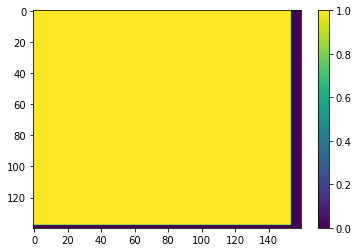

In [11]:
dimsd = data.shape
nwin = (42, 34)
nover = (10, 4)
nop = nwin
nwins = (4, 5)
dims = (nwins[0]*nop[0], nwins[1]*nop[1])

Op = Identity(nwin[0]*nwin[1], nwin[0]*nwin[1])

nwins, dims, mwin_inends, dwin_inends = patch2d_design(dimsd, nwin, nover, nop)
Sop = Patch2D(Op.H, dims, dimsd, nwin, nover, nop,
              tapertype='cosine')

y = Sop * np.ones(Sop.shape[1])

plt.figure()
plt.imshow(y.reshape(dimsd[0], dimsd[1]))
plt.colorbar()
plt.axis('tight');

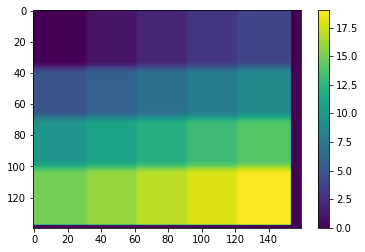

In [12]:
#with scalings
scalings = np.arange(nwins[0]*nwins[1])

Op = Identity(nwin[0]*nwin[1], nwin[0]*nwin[1])
Sop = Patch2D(Op.H, dims, dimsd, nwin, nover, nop,
              tapertype='cosine', scalings=scalings)

y = Sop * np.ones(Sop.shape[1])

plt.figure()
plt.imshow(y.reshape(dimsd[0], dimsd[1]))
plt.colorbar()
plt.axis('tight');

In [13]:
dimsd = data.shape
nwin = (42, 34)
nover = (10, 4)
nop = (64, 64)
dims = (4*64, 5*64)

Op = FFT2D(nwin, nffts=nop)

nwins, dims, mwin_inends, dwin_inends = patch2d_design(dimsd, nwin, nover, nop)
Sop = Patch2D(Op.H, dims, dimsd, nwin, nover, nop,
              tapertype=None)
Sop1 = Patch2D(Op.H, dims, dimsd, nwin, nover, nop,
              tapertype='cosine')

y = data.copy()
x = Sop.H * y.ravel()
x = x.reshape(dims)
xreshape = x.reshape(Sop.dims)
y1 = Sop1 * x.ravel()
y1 = np.real(y1).reshape(dimsd)

xinv = Sop1.div(y.ravel(), 5)

yinv = Sop1 * xinv.ravel()
yinv = np.real(yinv).reshape(dimsd)

dottest(Sop, Sop.shape[0],  Sop.shape[1], complexflag=2, atol=1e-2)

True

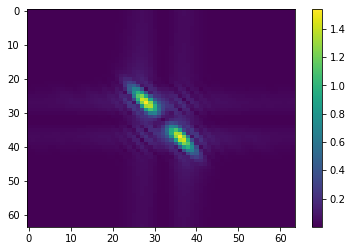

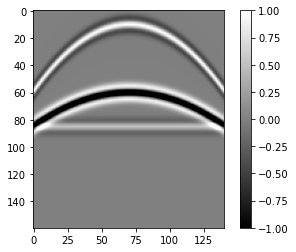

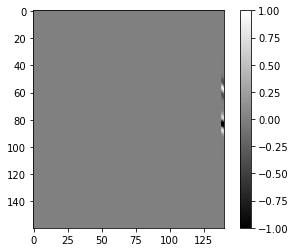

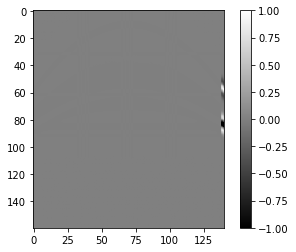

In [14]:
plt.figure()
plt.imshow(np.fft.fftshift(np.abs(x.ravel()[:nop[0]*nop[1]].reshape(nop).T)))
plt.colorbar()
plt.axis('tight')

plt.figure()
plt.imshow(y.T, cmap='gray',vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.imshow(y.T-y1.T, cmap='gray',vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.imshow(y.T-yinv.T, cmap='gray',vmin=-1, vmax=1)
plt.colorbar();

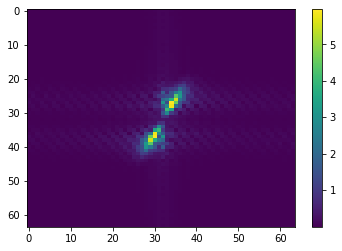

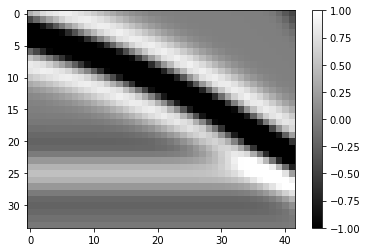

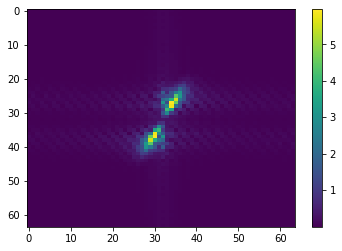

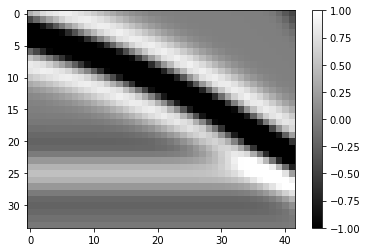

In [15]:
patches_inend = np.arange(0, nwins[0]*nwins[1]*nop[0]*nop[1], nop[0]*nop[1])
patches_inend = np.append(patches_inend, nwins[0]*nwins[1]*nop[0]*nop[1])

ipatch_x, ipatch_t = 3, 2
ipatch = ipatch_x*5 + ipatch_t

plt.figure()
plt.imshow(np.fft.fftshift(np.abs(x.ravel()[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
plt.colorbar()
plt.axis('tight')

plt.figure()
plt.imshow(np.real((Op.H * x.ravel()[patches_inend[ipatch]:patches_inend[ipatch+1]]).reshape(nwin)).T, cmap='gray', vmin=-1, vmax=1)
plt.colorbar()
plt.axis('tight')

plt.figure()
plt.imshow(np.fft.fftshift(np.abs(xreshape[ipatch_x, ipatch_t]).T))
plt.colorbar()
plt.axis('tight')

plt.figure()
plt.imshow(np.real((Op.H * xreshape[ipatch_x, ipatch_t].ravel()).reshape(nwin)).T, cmap='gray', vmin=-1, vmax=1)
plt.colorbar()
plt.axis('tight');

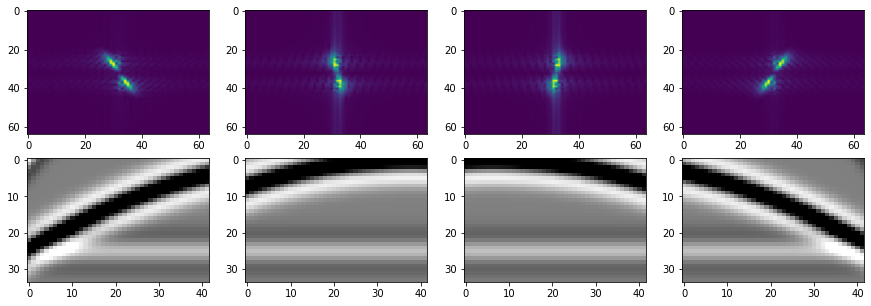

In [16]:
fig, axs = plt.subplots(2, 4, figsize=(15, 5))
for i in range(4):
    axs[0][i].imshow(np.fft.fftshift(np.abs(xreshape[i, 2]).T))
    axs[0][i].axis('tight')
    axs[1][i].imshow(np.real((Op.H * xreshape[i, 2].ravel()).reshape(nwin)).T, cmap='gray', vmin=-1, vmax=1)
    axs[1][i].axis('tight');

And now with only the positive frequency axis

In [17]:
dimsd = data.shape
nwin = (42, 34)
nover = (10, 4)
nop = (64, 64)
nop1 = (64, 33)
dims = (4*64, 5*33)

Op = FFT2D(nwin, nffts=nop, real=True)

nwins, dims, mwin_inends, dwin_inends = patch2d_design(dimsd, nwin, nover, nop1)
Sop = Patch2D(Op.H, dims, dimsd, nwin, nover, nop1,
              tapertype=None)
Sop1 = Patch2D(Op.H, dims, dimsd, nwin, nover, nop1,
              tapertype='cosine')

y = data.copy()
x = Sop.H * y.ravel()
x = x.reshape(dims)
xreshape = x.reshape(Sop.dims)
y1 = Sop1 * x.ravel()
y1 = np.real(y1).reshape(dimsd)

xinv = Sop1.div(y.ravel(), 5)

yinv = Sop1 * xinv.ravel()
yinv = np.real(yinv).reshape(dimsd)

#dottest(Sop, Sop.shape[0],  Sop.shape[1], complexflag=0, atol=1e-2)

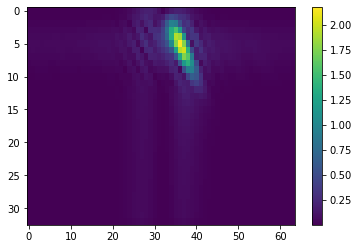

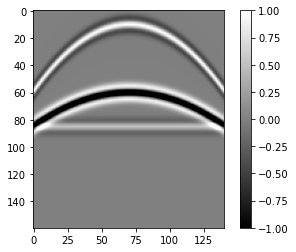

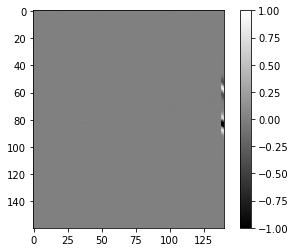

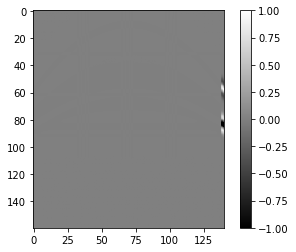

In [18]:
plt.figure()
plt.imshow(np.fft.fftshift(np.abs(x.ravel()[:nop1[0]*nop1[1]].reshape(nop1).T), axes=1))
plt.colorbar()
plt.axis('tight')

plt.figure()
plt.imshow(y.T, cmap='gray',vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.imshow(y.T-y1.T, cmap='gray',vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.imshow(y.T-yinv.T, cmap='gray',vmin=-1, vmax=1)
plt.colorbar();

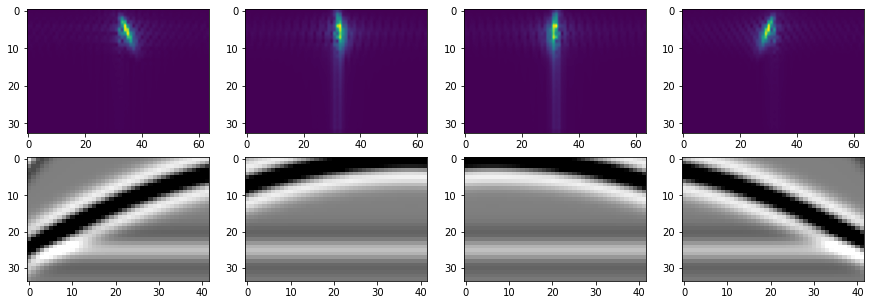

In [19]:
fig, axs = plt.subplots(2, 4, figsize=(15, 5))
for i in range(4):
    axs[0][i].imshow(np.fft.fftshift(np.abs(xreshape[i, 2]).T, axes=1))
    axs[0][i].axis('tight')
    axs[1][i].imshow(np.real((Op.H * xreshape[i, 2].ravel()).reshape(nwin)).T, cmap='gray', vmin=-1, vmax=1)
    axs[1][i].axis('tight');

## 3d patches

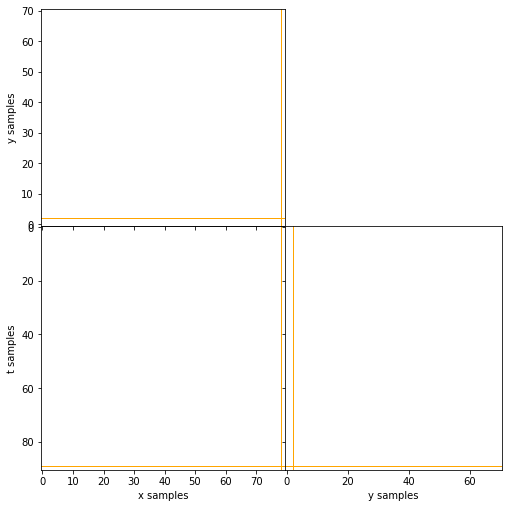

In [20]:
ny, nx, nt = 91, 80, 71
data = np.ones((ny, nx, nt))

dimsd = data.shape
nwin = (21, 10, 7)
nover = (7, 5, 3)
nwins = (6, 15, 17)
#dims = (nwins[0]*nwin[0], nwins[1]*nwin[1], nwins[2]*nwin[2])

Op = Identity(nwin[0]*nwin[1]*nwin[2], nwin[0]*nwin[1]*nwin[2])

nwins, dims, mwin_inends, dwin_inends = patch3d_design(dimsd, nwin, nover, nwin)
Sop = Patch3D(Op.H, dims, dimsd, nwin, nover, nwin,
              tapertype=None)
S1op = Patch3D(Op.H, dims, dimsd, nwin, nover, nwin,
              tapertype='cosine')

y = S1op * np.ones(Sop.shape[1])
y = y.reshape(dimsd[0], dimsd[1], dimsd[2])

explode_volume(y, t=ny-2, x=nx-2, y=2)

## 2d Interpolation

In [21]:
inputfile = '../../pylops/testdata/marchenko/input.npz'
inputdata = np.load(inputfile)

x = inputdata['R'][50, :, :-100]
x = x/np.abs(x).max()

taxis, xaxis = inputdata['t'][:-100], inputdata['r'][0]
par = {}
par['nx'], par['nt'] = x.shape
par['dx'] = inputdata['r'][0, 1] - inputdata['r'][0, 0]
par['dt'] = inputdata['t'][1] - inputdata['t'][0]

# add wavelet
wav = 0.3*inputdata['wav']
wav_c = np.argmax(wav)
x = np.apply_along_axis(convolve, 1, x, wav, mode='full')
x = x[:, wav_c:][:, :par['nt']]

# gain
gain = np.tile((taxis**2)[:, np.newaxis], (1, par['nx'])).T
x = x*gain

# irregular subsampling
np.random.seed(5)
perc_subsampling=0.6
Nsub=int(np.round(par['nx']*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub])

# regular subsampling
#iava = np.arange(par['nx'])[::5]
#Nsub = len(iava)

# Create restriction operator
Rop = Restriction((par['nx'], par['nt']), iava, axis=0, dtype='float64')
dottest(Rop,Nsub*par['nt'],par['nx']*par['nt'], verb=True)

# Create fft operator
nfft=2**10
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft, nfft], 
              sampling=[par['dx'], par['dt']])

# Data
y = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nt'])
xadj = xadj.reshape(par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^H(Opu)=400.0701114689231 - u^H(Op^Hv)=400.070111468923


In [22]:
dimsd = x.shape
nwin = (20, 34)
nover = (10, 4)
nop = (64, 64)

Fop = FFT2D(nwin, nffts=nop)

nwins, dims, mwin_inends, dwin_inends = patch2d_design(dimsd, nwin, nover, nop)
Sop = Patch2D(Fop.H, dims, dimsd, nwin, nover, nop,
              tapertype='hanning', # 'cosine'
              )
#p = Sop.H * x.ravel()
p = Sop.div(x.ravel(), 50)
pmask = Sop.div(ymask.ravel(), 50)

dottest(Sop, Sop.shape[0],  Sop.shape[1], complexflag=2, atol=1e-2)

 540 570 600 630 660], end:[ 34  64  94 124 154 184 214 244 274 304 334 364 394 424 454 484 514 544
 574 604 634 664 694]
  896  960 1024 1088 1152 1216 1280 1344 1408], end:[  64  128  192  256  320  384  448  512  576  640  704  768  832  896
  960 1024 1088 1152 1216 1280 1344 1408 1472]


True

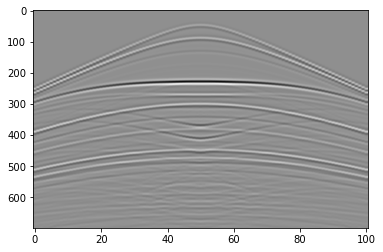

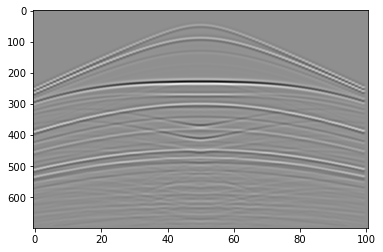

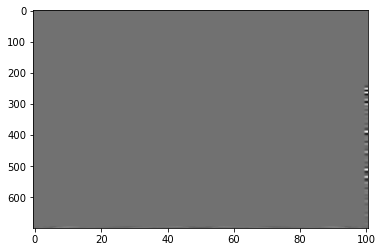

In [23]:
plt.figure()
plt.imshow(x.T, cmap='gray')
plt.axis('tight')

plt.figure()
plt.imshow(np.real(Sop * p).reshape(par['nx'], par['nt']).T, cmap='gray')
plt.axis('tight');

plt.figure()
plt.imshow(x.T - np.real(Sop * p).reshape(par['nx'], par['nt']).T, cmap='gray')
plt.axis('tight');

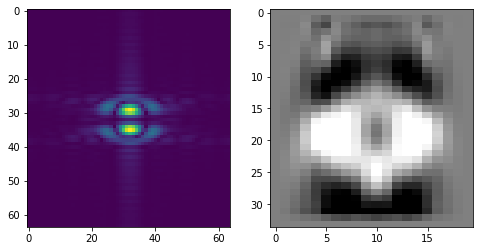

In [24]:
patches_inend = np.arange(0, nwins[0]*nwins[1]*nop[0]*nop[1], nop[0]*nop[1])
patches_inend = np.append(patches_inend, nwins[0]*nwins[1]*nop[0]*nop[1])

ipatch = 4*23 + 18

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(p[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * p[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

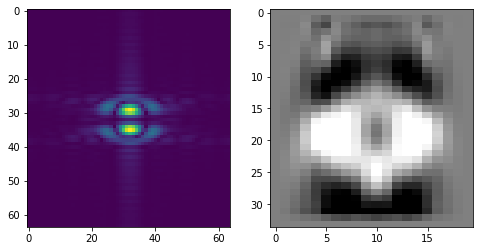

In [25]:
preshape = p.reshape(Sop.dims)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(preshape[4, 18].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * preshape[4, 18].ravel()).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

In [26]:
def callback(x, xhistory, Pop, xshape, xtrue=None, xerror=None):
    x = np.real(Pop * x).reshape(xshape).T
    xhistory.append(x)
    if xtrue is not None:
        xerror.append(np.linalg.norm(x-xtrue))

In [ ]:
# Synthesis problem with fixed thresholding
Op = Rop * Sop

niters = 100
xhist = []
xerror = []
prec, _, cost = fista(Op, y.ravel(), niter=niters, eps=5e-3, alpha=2.5e-1, #eigsiter=10, eigstol=1e-1, 
                      tol=1e-10, show=True, 
                      callback=lambda xinv: callback(xinv, xhist, Sop, (par['nx'], par['nt']), x.T, xerror))
xrec = np.real(Sop * prec)
xrec = xrec.reshape(par['nx'], par['nt'])
print('MSE', np.linalg.norm(x.T-xrec.T))

plt.figure()
plt.plot(cost, 'k')

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xrec.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xrec.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 42700 rows and 847872 cols
eps = 5.000000e-03	tol = 1.000000e-10	niter = 100
alpha = 2.500000e-01	thresh = 6.250000e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   -0.00e+00+0.00e+00j    7.798e-01   8.887e-01   2.007e-01
     2   -0.00e+00+0.00e+00j    6.381e-01   8.322e-01   1.647e-01
     3   -0.00e+00+0.00e+00j    5.095e-01   7.894e-01   1.751e-01
     4   -0.00e+00+0.00e+00j    4.044e-01   7.629e-01   1.722e-01
     5   -0.00e+00+0.00e+00j    3.244e-01   7.498e-01   1.608e-01
     6   -0.00e+00+0.00e+00j    2.664e-01   7.448e-01   1.454e-01
     7   -0.00e+00+0.00e+00j    2.256e-01   7.433e-01   1.294e-01
     8   -0.00e+00+0.00e+00j    1.973e-01   7.418e-01   1.154e-01
     9   -0.00e+00+0.00e+00j    1.778e-01   7.389e-01   1.041e-01
    10   -0.0

In [ ]:
patches_inend = np.arange(0, nwins[0]*nwins[1]*nop[0]*nop[1], nop[0]*nop[1])
patches_inend = np.append(patches_inend, nwins[0]*nwins[1]*nop[0]*nop[1])

ipatch = 4*23 + 8

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(p[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * p[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(pmask[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * pmask[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(prec[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * prec[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

In [ ]:
X = (FFTop * x.ravel()).reshape(nfft, nfft)
Y = (FFTop * ymask.ravel()).reshape(nfft, nfft)
Xrec = (FFTop * xrec.ravel()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(np.fft.fftshift(np.abs(X[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[0].set_title('X')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[1].imshow(np.fft.fftshift(np.abs(Y[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[1].set_title('Ymask')
axs[1].axis('tight')
axs[1].set_ylim(50, 0);
axs[2].imshow(np.fft.fftshift(np.abs(Xrec[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[2].set_title('Xrec')
axs[2].axis('tight')
axs[2].set_ylim(50, 0)
axs[3].imshow(np.abs(np.fft.fftshift(np.abs(X[:, :nfft//2-1]),axes=0).T -
              np.fft.fftshift(np.abs(Xrec[:, :nfft//2-1]),axes=0).T), cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[3].set_title('Rec error')
axs[3].axis('tight')
axs[3].set_ylim(50, 0);

In [ ]:
inversion_widget(ymask.T, xhist, cost, error=np.array(xerror), model_true=x.T, title='Reconstruction Widget')

In [ ]:
# Synthesis problem with thresholding decay
eps = 5e-3
niter = 100
decay = (np.exp(-0.05*np.arange(niter)) + 0.2) / 1.2
plt.figure()
plt.plot(eps*decay, 'k')

xhist = []
xerror = []
prec, _, cost = fista(Op, y.ravel(), niter=niter, eps=eps, alpha=2.5e-1, #eigsiter=10, eigstol=1e-1, 
                      decay=decay, tol=1e-10, show=True,
                      callback=lambda xinv: callback(xinv, xhist, Sop, (par['nx'], par['nt']), x.T, xerror))


xrec = np.real(Sop * prec)
xrec = xrec.reshape(par['nx'], par['nt'])
print('MSE', np.linalg.norm(x.T-xrec.T))

plt.figure()
plt.plot(cost, 'k')

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xrec.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xrec.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

In [ ]:
patches_inend = np.arange(0, nwins[0]*nwins[1]*nop[0]*nop[1], nop[0]*nop[1])
patches_inend = np.append(patches_inend, nwins[0]*nwins[1]*nop[0]*nop[1])

ipatch = 4*23 + 8

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(p[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * p[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(pmask[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * pmask[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(prec[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * prec[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

In [ ]:
X = (FFTop* x.ravel()).reshape(nfft, nfft)
Y = (FFTop* ymask.ravel()).reshape(nfft, nfft)
Xrec = (FFTop * xrec.ravel()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(np.fft.fftshift(np.abs(X[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[0].set_title('X')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[1].imshow(np.fft.fftshift(np.abs(Y[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[1].set_title('Ymask')
axs[1].axis('tight')
axs[1].set_ylim(50, 0);
axs[2].imshow(np.fft.fftshift(np.abs(Xrec[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[2].set_title('Xrec')
axs[2].axis('tight')
axs[2].set_ylim(50, 0)
axs[3].imshow(np.abs(np.fft.fftshift(np.abs(X[:, :nfft//2-1]),axes=0).T -
              np.fft.fftshift(np.abs(Xrec[:, :nfft//2-1]),axes=0).T), cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[3].set_title('Rec error')
axs[3].axis('tight')
axs[3].set_ylim(50, 0);

In [ ]:
inversion_widget(ymask.T, xhist, cost, error=np.array(xerror), model_true=x.T, title='Reconstruction Widget')

In [ ]:
# Analysis problem
eps = 5e-3
niter = 100
decay = (np.exp(-0.05*np.arange(niter)) + 0.2) / 1.2
plt.figure()
plt.plot(eps*decay, 'k')

Rop.dtype = np.complex128
xrec, _, cost = fista(Rop, y.ravel(), niter=niter, eps=eps, alpha=1., #eigsiter=10, eigstol=1e-1, 
                      SOp=Sop, decay=decay, tol=1e-10, show=True)
xrec = np.real(xrec.reshape(par['nx'], par['nt']))
print('MSE', np.linalg.norm(x.T-xrec.T))

plt.figure()
plt.plot(cost, 'k')

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xrec.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xrec.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

In [ ]:
X = (FFTop* x.ravel()).reshape(nfft, nfft)
Y = (FFTop* ymask.ravel()).reshape(nfft, nfft)
Xrec = (FFTop * xrec.ravel()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(np.fft.fftshift(np.abs(X[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[0].set_title('X')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[1].imshow(np.fft.fftshift(np.abs(Y[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[1].set_title('Ymask')
axs[1].axis('tight')
axs[1].set_ylim(50, 0);
axs[2].imshow(np.fft.fftshift(np.abs(Xrec[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[2].set_title('Xrec')
axs[2].axis('tight')
axs[2].set_ylim(50, 0)
axs[3].imshow(np.abs(np.fft.fftshift(np.abs(X[:, :nfft//2-1]),axes=0).T -
              np.fft.fftshift(np.abs(Xrec[:, :nfft//2-1]),axes=0).T), cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[3].set_title('Rec error')
axs[3].axis('tight')
axs[3].set_ylim(50, 0);